In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn
import random
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#data modeling libs
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn import feature_selection, model_selection as ms, metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize']=12,8



Explore data

In [2]:
#look at data
data_raw = pd.read_csv('C:/Users/Joeri Kiekens/Desktop/edX MOOCs/capstone data science/train_values.csv')
data_test = pd.read_csv('C:/Users/Joeri Kiekens/Desktop/edX MOOCs/capstone data science/test_values.csv')
data_raw_labels = pd.read_csv('C:/Users/Joeri Kiekens/Desktop/edX MOOCs/capstone data science/train_labels.csv')

data1= data_raw.copy(deep = True)
data1['label']=data_raw_labels['accepted']
data_cleaner = [data1,data_test]

#based on report
#data_raw['applicant_ethnicity']=data_raw['applicant_ethnicity'].map({1:'1_3',3:'1_3',2:2,4:4})
#data_raw['applicant_race']=data_raw['applicant_race'].map({7:'7-1-4',1:'7-1-4',4:'7-1-4',5:'5',2:'2-3-6',3:'2-3-6',6:'2-3-6'})

print('train columns with nans/missing vals BEFORE cleaning:\n',data1.isnull().sum())
print('_'*25)
print('test columns with nans/missing vals BEFORE cleaning:\n',data_test.isnull().sum())

#before dropping nans: remember who didn't fill in (population,
#minority pct, ffiecmedian, tract, number of owner occ, fam units)
#because of 22k people not filling in only 1000 get accepted
#so if you're a skipper, things looking bad for you
for dataset in data_cleaner:
    dataset['skippers']='0'
    dataset.loc[(dataset['population'].isnull()) & (dataset['ffiecmedian_family_income'].isnull()) &
                (dataset['number_of_1_to_4_family_units'].isnull()),'skippers']='1'
    #blank applicant income 40k entries, but 20k entries got it, so skipping income box isn't the dealbreaker for getting a loan

#deal with missing data: fillna for applicant income
fill_cols = ['applicant_income','population','minority_population_pct','ffiecmedian_family_income','tract_to_msa_md_income_pct',
            'number_of_owner-occupied_units','number_of_1_to_4_family_units']
for dataset in data_cleaner:
    dataset['applicant_income'].fillna(dataset['applicant_income'].median(),inplace=True)
    dataset['population'].fillna(dataset['population'].median(),inplace=True)
    dataset['minority_population_pct'].fillna(dataset['minority_population_pct'].median(),inplace=True)
    dataset['ffiecmedian_family_income'].fillna(dataset['ffiecmedian_family_income'].median(),inplace=True)
    dataset['tract_to_msa_md_income_pct'].fillna(dataset['tract_to_msa_md_income_pct'].median(),inplace=True)
    dataset['number_of_owner-occupied_units'].fillna(dataset['number_of_owner-occupied_units'].median(),inplace=True)
    dataset['number_of_1_to_4_family_units'].fillna(dataset['number_of_1_to_4_family_units'].median(),inplace=True)

#remove outliers from train data
#any loan amount larger than 1000
data1.drop(data1[data1['loan_amount']>500].index,inplace=True)
data1.drop(data1[data1['applicant_income']>400].index,inplace=True)
#data1.drop(data1[data1['population']>20000].index,inplace=True)    
#data1.drop(data1[data1['number_of_owner-occupied_units']>6000].index,inplace=True)
#data1.drop(data1[data1['number_of_1_to_4_family_units']>8000].index,inplace=True)

# #additional features
for dataset in data_cleaner:
    

    #compare income applicant to median tract
    dataset['income_applicant-median_tract']=dataset['applicant_income']*1000-dataset[
        'tract_to_msa_md_income_pct']/100*dataset['ffiecmedian_family_income']
    
    dataset['population_minority']=dataset['population']*dataset['minority_population_pct']/100
    
    dataset['not_msa_area']='1'
    dataset.loc[dataset['msa_md']==-1,'not_msa_area']='0'
    
    dataset['not_county_area']='1'
    dataset.loc[dataset['county_code']==-1,'not_county_area']='0'    
    
    #a measure of income to loan amount
    dataset['MHE']=dataset['loan_amount']-3*dataset['applicant_income']
    
    #open housing
    dataset['open_housing']=dataset['number_of_1_to_4_family_units']-dataset['number_of_owner-occupied_units']
#     #compare income applicant to median msa
#     dataset['income_applicant-median_msa']=dataset['applicant_income']*1000-dataset['ffiecmedian_family_income']
#     dataset['income_applicant-median_msa']=np.log1p(dataset['income_applicant-median_msa']-min(dataset['income_applicant-median_msa']))
    dataset['company']='0'
    dataset.loc[(dataset['applicant_ethnicity']==4) & (dataset['applicant_race']==7) & (dataset['applicant_sex']==4),'company']='1'
    
#convert formats
for dataset in data_cleaner:
    dataset['applicant_race']=dataset['applicant_race'].astype(str)
    dataset['applicant_sex']=dataset['applicant_sex'].astype(str)
    dataset['applicant_ethnicity']=dataset['applicant_ethnicity'].astype(str)
#    dataset['applicant_ethnicity_bin']=dataset['applicant_ethnicity_bin'].astype(str)
    dataset['property_type']=dataset['property_type'].astype(str)
    dataset['loan_type']=dataset['loan_type'].astype(str)
    dataset['preapproval']=dataset['preapproval'].astype(str)
    dataset['loan_purpose']=dataset['loan_purpose'].astype(str)
    dataset['occupancy']=dataset['occupancy'].astype(str)
#    dataset['loan_amount_bin_group']=dataset['loan_amount_bin_group'].astype(str)  
    dataset['lender']=dataset['lender'].astype(str)
print('train columns with nans/missing vals AFTER cleaning:\n',data1.isnull().sum())
print('_'*25)
print('test columns with nans/missing vals AFTER cleaning:\n',data_test.isnull().sum())
print(data1.info())
print(data_test.info())

train columns with nans/missing vals BEFORE cleaning:
 row_id                                0
loan_type                             0
property_type                         0
loan_purpose                          0
occupancy                             0
loan_amount                           0
preapproval                           0
msa_md                                0
state_code                            0
county_code                           0
applicant_ethnicity                   0
applicant_race                        0
applicant_sex                         0
applicant_income                  39948
population                        22465
minority_population_pct           22466
ffiecmedian_family_income         22440
tract_to_msa_md_income_pct        22514
number_of_owner-occupied_units    22565
number_of_1_to_4_family_units     22530
lender                                0
co_applicant                          0
accepted                              0
label                    

In [3]:
#log transform non normal num distributions
num_cols_logtf = ['applicant_income','minority_population_pct','ffiecmedian_family_income']

num_cols_sqrttf = ['loan_amount']

for dataset in data_cleaner:
    for col in num_cols_logtf:
        dataset[col]=np.log1p(dataset[col])
    for col in num_cols_sqrttf:
        dataset[col]=np.sqrt(dataset[col])

        #negative values need special treatment
for dataset in data_cleaner:
    dataset['income_applicant-median_tract']=np.log1p(dataset['income_applicant-median_tract']-min(dataset['income_applicant-median_tract']))
    #dataset['open_housing']=np.log1p(dataset['open_housing']-min(dataset['open_housing']))



In [50]:
data_raw45=data_raw[data_raw['state_code']==45]
data_raw45[['applicant_income','loan_amount']].corr()

,applicant_income,loan_amount
applicant_income,1.000000,0.629981
loan_amount,0.629981,1.000000


In [4]:
#acceptance rates
# data1['map_dummy']=data1['state_code'].astype(str)+data1['county_code'].astype(str)
# data_test['map_dummy']=data_test['state_code'].astype(str)+data_test['county_code'].astype(str)
data1['county_dummy']=data1['state_code']+data1['county_code']
data_test['county_dummy']=data_test['state_code']+data_test['county_code']

data1['acceptance_rate_lender']=data1.groupby('lender')['label'].transform(lambda x: x.mean()*100)
data1['acceptance_rate_msa']=data1.groupby('msa_md')['label'].transform(lambda x: x.mean()*100)
data1['acceptance_rate_state']=data1.groupby('state_code')['label'].transform(lambda x: x.mean()*100)
data1['acceptance_rate_county']=data1.groupby('county_dummy')['label'].transform(lambda x: x.mean()*100)

map_lender = dict(zip(data1['lender'],data1['acceptance_rate_lender']))
map_lender_msa = dict(zip(data1['msa_md'],data1['acceptance_rate_msa']))
map_lender_state = dict(zip(data1['state_code'],data1['acceptance_rate_state']))
map_lender_county = dict(zip(data1['county_dummy'],data1['acceptance_rate_county']))


data_test['acceptance_rate_lender']=data_test['lender'].map(map_lender)
data_test['acceptance_rate_msa']=data_test['msa_md'].map(map_lender_msa)
data_test['acceptance_rate_state']=data_test['state_code'].map(map_lender_state)
data_test['acceptance_rate_county']=data_test['county_dummy'].map(map_lender_county)

#lenders in test set not in train set gives nans in test set
data_test['acceptance_rate_lender'].fillna(50,inplace=True)
data_test['acceptance_rate_msa'].fillna(50,inplace=True)
data_test['acceptance_rate_state'].fillna(50,inplace=True)
data_test['acceptance_rate_county'].fillna(50,inplace=True)

# data_test['acceptance_rate_msa']=data_test['acceptance_rate_msa'].apply(int)

In [62]:
data148=data1[(data1['state_code']==2) | (data1['state_code']==4)]
data148[['acceptance_rate_state']].describe()

,acceptance_rate_state
count,42825.000000
mean,48.667834
std,5.222524
min,45.440465
25%,45.440465
50%,45.440465
75%,57.118716
max,57.118716


In [28]:
print(data1.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488713 entries, 0 to 499999
Data columns (total 38 columns):
row_id                               488713 non-null int64
loan_type                            488713 non-null object
property_type                        488713 non-null object
loan_purpose                         488713 non-null object
occupancy                            488713 non-null object
loan_amount                          488713 non-null float64
preapproval                          488713 non-null object
msa_md                               488713 non-null int64
state_code                           488713 non-null int64
county_code                          488713 non-null int64
applicant_ethnicity                  488713 non-null object
applicant_race                       488713 non-null object
applicant_sex                        488713 non-null object
applicant_income                     488713 non-null float64
population                           488713 non-nul

Visualization

In [36]:
#report section
#summary statistics
sum_data=data_raw[['minority_population_pct','loan_amount','applicant_income','population','ffiecmedian_family_income','tract_to_msa_md_income_pct',
          'number_of_owner-occupied_units','number_of_1_to_4_family_units','lender']]
table=sum_data.describe()
table_select = table.iloc[[1,2,3,5,7,0],:]
table_select.rename(index = {'count':'# entries','std':'stand. dev.','50%':'median','min':'minimum','max':'maximum'},
                    columns={'minority_population_pct':'Minority population in tract (%)','tract_to_msa_md_income_pct':'Tract median/MSA median\n(%)','loan_amount':'Loan Amount\n(k$)','applicant_income':'Applicant Income\n(k$)','population':'Population in tract',
                            'ffiecmedian_family_income':'MSA median family income\n($)','number_of_owner-occupied_units':'Occupied living units in tract',
                            'number_of_1_to_4_family_units':'1-4 family units in tract'},inplace=True)
table_select=table_select.round(0).astype(int)


In [12]:
table_select.to_clipboard()

In [13]:
#map for nice data names
data_raw['loan_purpose2']=data_raw['loan_purpose'].map({1:'Buy Home',2:'Improve',3:'Refinance'})

col_0      count
accepted        
0         249886
1         250114


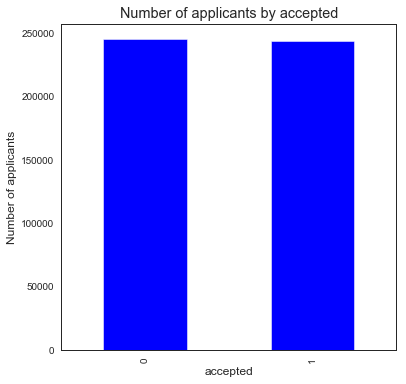

col_0       count
loan_type        
1          370827
2           82430
3           39521
4            7222


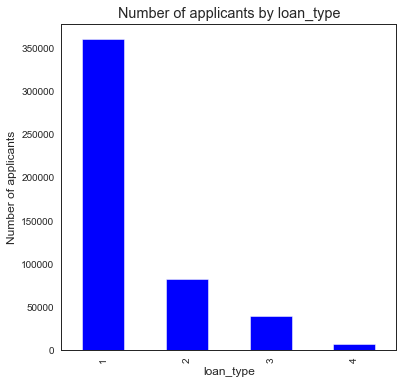

col_0           count
property_type        
1              478217
2               19741
3                2042


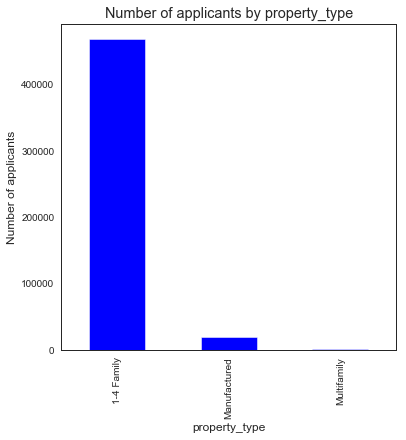

col_0          count
loan_purpose        
1             209265
2              48065
3             242670


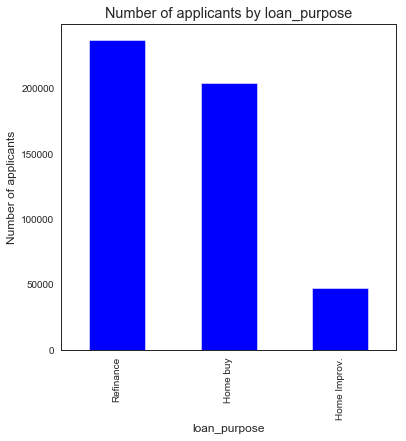

col_0       count
occupancy        
1          447394
2           50417
3            2189


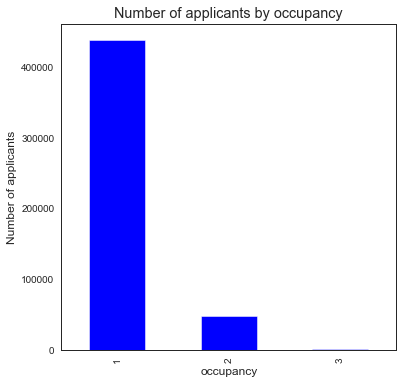

col_0                 count
applicant_ethnicity        
1                     50822
2                    386061
3                     57298
4                      5819


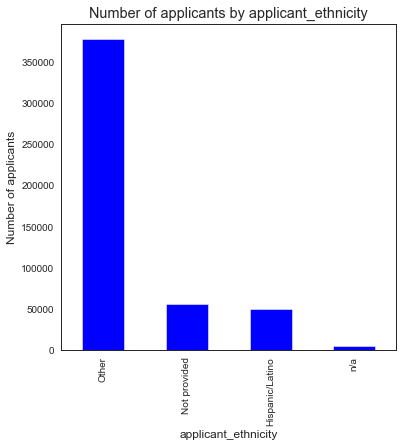

col_0            count
applicant_race        
1                 4332
2                25756
3                40495
4                 2339
5               361538
6                59862
7                 5678


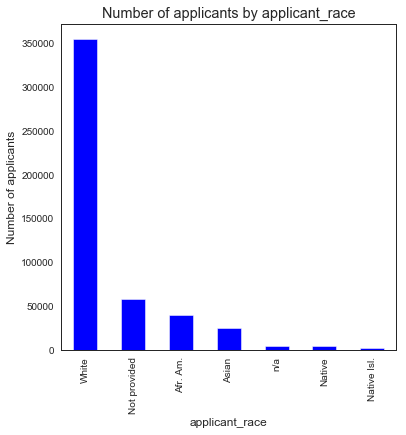

col_0           count
applicant_sex        
1              315806
2              142876
3               35643
4                5675


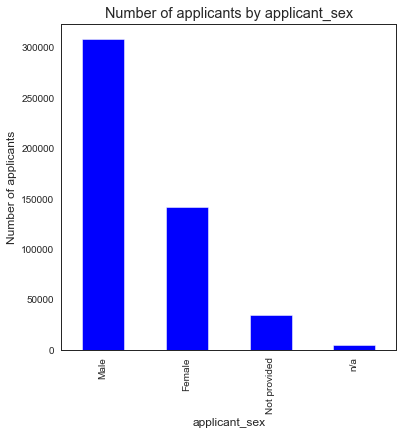

col_0          count
co_applicant        
False         299974
True          200026


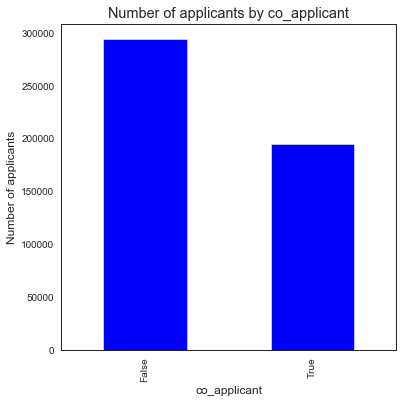

In [71]:
##4. Visualization
#look at label
def plot_bars(data,cols):
    for col in cols:
        
        my_tab = pd.crosstab(index=data_raw[col],  # Make a crosstab
                              columns="count")
        print(my_tab)
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
        counts =data[col].value_counts()
        counts.plot.bar(ax=ax,color='blue')
        ax.set_title('Number of applicants by '+col)
        ax.set_xlabel(col)
        ax.set_ylabel('Number of applicants')
        plt.savefig(col+'.png')
        plt.show()
plot_cols=['accepted','loan_type','property_type','loan_purpose','occupancy','applicant_ethnicity','applicant_race','applicant_sex','co_applicant']
#plot_cols = ['loan_purpose2']
plot_bars(data1,plot_cols)

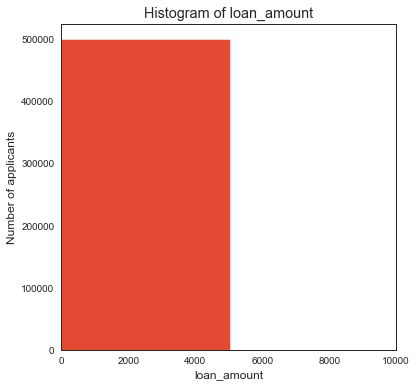

In [47]:
def plot_histogram(data,cols,bins=20):
    for col in cols:
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
        data[col].plot.hist(ax=ax,bins=bins)
        ax.set_xlim(0,10000)
        #ax.set_ylim(0,10)
        ax.set_title('Histogram of '+col)
        ax.set_xlabel(col)
        ax.set_ylabel('Number of applicants')
        plt.savefig('hist'+col+'.png')
        plt.show()
        #'loan_amount','applicant_income','MHE','income_applicant-median_tract_log','population_minority'
#num_cols=['open_housing','MHE','income_applicant-median_tract','income_applicant-median_tract_log','population_minority','loan_amount','applicant_income','population_minority','population','minority_population_pct','ffiecmedian_family_income','tract_to_msa_md_income_pct','number_of_owner-occupied_units','number_of_1_to_4_family_units']
#num_cols = ['loan_amount','applicant_income','ffiecmedian_family_income','tract_to_msa_md_income_pct','minority_population_pct','acceptance_rate_lender','acceptance_rate_msa','acceptance_rate_state','acceptance_rate_county','income_applicant-median_tract']
#num_cols=['minority_population_pct','loan_amount','applicant_income','ffiecmedian_family_income','number_of_1_to_4_family_units','number_of_owner-occupied_units']
plot_histogram(data_raw,['loan_amount'])

loan_purpose


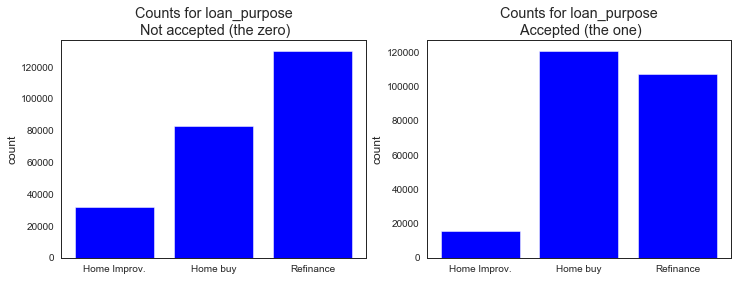

property_type


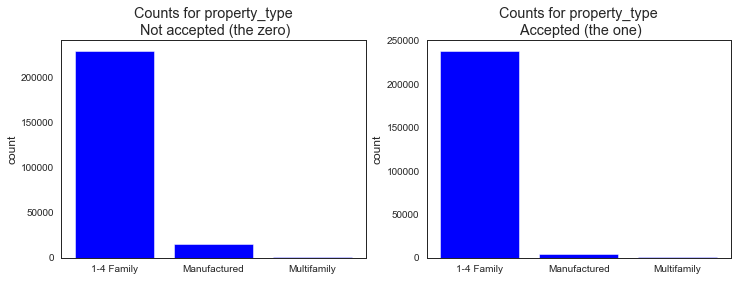

preapproval


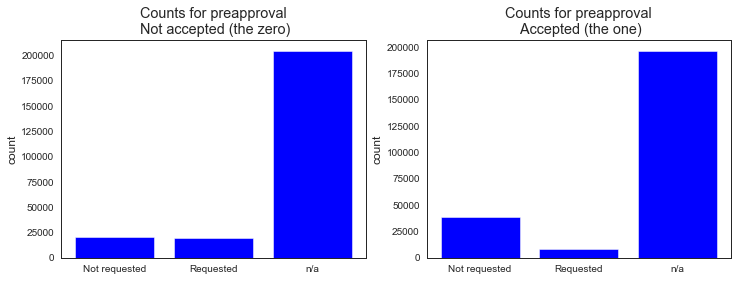

applicant_ethnicity


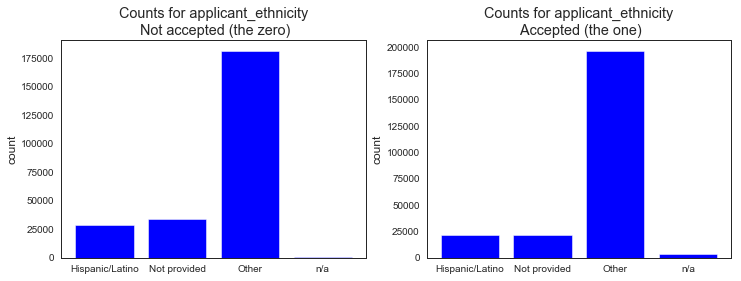

applicant_race


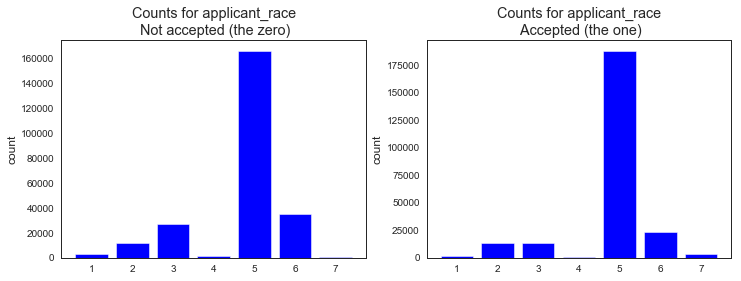

applicant_sex


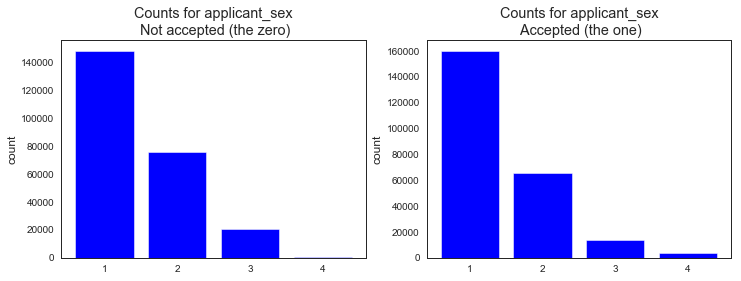

co_applicant


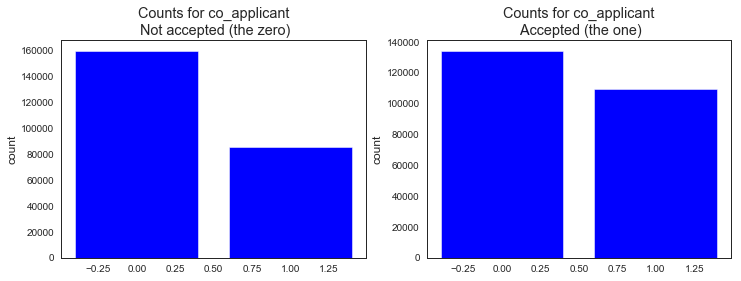

skippers


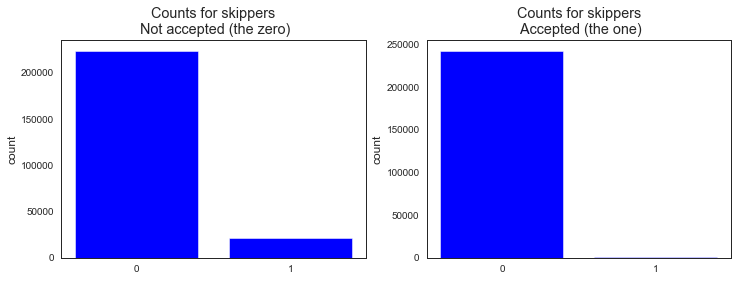

In [34]:
#cat cat - 2D
#cat_cols = data1.select_dtypes('object').columns
#print(cat_cols)
# cat_cols = ['open_units_bin_group','loan_type', 'property_type', 'loan_purpose','loan_purpose_bin', 'occupancy',
#        'preapproval', 'msa_bin', 'state_code_bin', 'county_code_bin',
#        'applicant_ethnicity','applicant_ethnicity_bin', 'applicant_race', 'applicant_race_bin','applicant_sex','applicant_sex_bin'
#             , 'income_bin1','loan_amount_bin','loan_amount_bin_group','high_median_income'
#            ,'co_applicant','minority_bin','higher_than_msa_income','high_salary','open_units_bin']

#data1['loan_amountbin']=pd.cut(data1['loan_amount'],100)
#data1['applicant_incomebin']=pd.cut(data1['applicant_income'],100).astype(str)

#all cat cols
#cat_cols = ['loan_type','property_type','loan_purpose','occupancy','preapproval','applicant_ethnicity','applicant_race','applicant_sex','co_applicant','skippers']

cat_cols = ['loan_purpose','property_type','preapproval','applicant_ethnicity','applicant_race','applicant_sex','co_applicant','skippers']

data1['dummy'] = np.ones(shape = data1.shape[0])
for col in cat_cols:
    print(col)
    counts = data1[['dummy', 'label', col]].groupby(['label', col], as_index = False).count()
    temp = counts[counts['label'] == 0][[col, 'dummy']]
    _ = plt.figure(figsize = (12,4))
    plt.subplot(1, 2, 1)
    temp = counts[counts['label'] == 0][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy, color='blue')
    #plt.xticks(rotation=90)
    plt.title('Counts for ' + col + '\n Not accepted (the zero)')
    #plt.ylim(0,100)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    temp = counts[counts['label'] == 1][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy, color='blue')
    #plt.xticks(rotation=90)
    plt.title('Counts for ' + col + '\n Accepted (the one)')
    #plt.ylim(0,100)
    plt.ylabel('count')
    plt.savefig('comp '+col+'.png')
    plt.show()


co_applicant


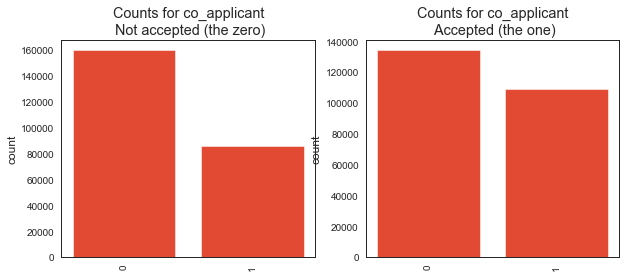

skippers


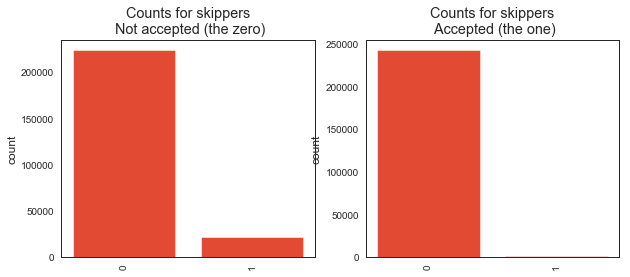

In [147]:
cat_cols = ['co_applicant','skippers']

data1['dummy'] = np.ones(shape = data1.shape[0])
for col in cat_cols:
    print(col)
    counts = data1[['dummy', 'label', col]].groupby(['label', col], as_index = False).count()
    temp = counts[counts['label'] == 0][[col, 'dummy']]
    _ = plt.figure(figsize = (10,4))
    plt.subplot(1, 2, 1)
    temp = counts[counts['label'] == 0][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks([0,1])
    plt.title('Counts for ' + col + '\n Not accepted (the zero)')
    #plt.ylim(0,100)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    temp = counts[counts['label'] == 1][[col, 'dummy']]
    plt.bar(temp[col], temp.dummy)
    plt.xticks([0,1])
    plt.title('Counts for ' + col + '\n Accepted (the one)')
    #plt.ylim(0,100)
    plt.ylabel('count')
    plt.savefig('comp '+col+'.png')
    plt.show()


In [5]:
##map values from int categories to text

cols = ['loan_purpose','property_type','preapproval','applicant_ethnicity','loan_type','applicant_race','applicant_sex']
map_loan_p = {'1': 'Home buy','2': 'Home Improv.','3': 'Refinance'}
map_prop_t = {'1':'1-4 Family','2':'Manufactured','3':'Multifamily'}
map_preap = {'1':'Requested','2':'Not requested','3':'n/a'}
map_eth = {'1':'Hispanic/Latino', '2':'Other','3':'Not provided','4':'n/a'}
map_loant = {'1':'Conventional','2':'FHA','3':'VA-guaranteed','4':'FSA/RHS'}
map_race = {'1':'Native','2':'Asian','3':'Afr. Am.','4':'Native Isl.','5':'White','6':'Not provided','7':'n/a'}
map_sex = {'1':'Male','2':'Female','3':'Not provided','4':'n/a'}
map_list = [map_loan_p,map_prop_t,map_preap,map_eth,map_loant,map_race,map_sex]

for i,col in enumerate(cols):
    data1[col]=data1[col].map(map_list[i])
data1[cols].head()

,loan_purpose,property_type,preapproval,applicant_ethnicity,loan_type,applicant_race,applicant_sex
0,Home buy,1-4 Family,n/a,Other,VA-guaranteed,White,Male
1,Refinance,1-4 Family,n/a,Hispanic/Latino,Conventional,White,Male
2,Refinance,1-4 Family,n/a,Other,FHA,White,Male
3,Home buy,1-4 Family,Requested,Other,Conventional,White,Male
4,Home buy,1-4 Family,n/a,Other,Conventional,Afr. Am.,Female


In [44]:
data1['loan_type'].head()

0    VA-guaranteed
1     Conventional
2              FHA
3     Conventional
4     Conventional
Name: loan_type, dtype: object

ValueError: Could not interpret input 'acceptance_rate_county'

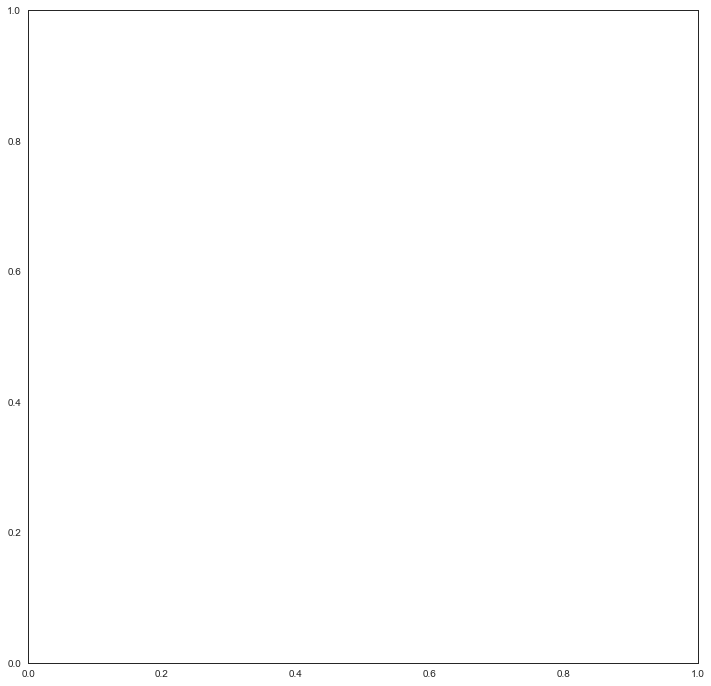

In [52]:
fig, ax=plt.subplots(1,1,figsize=(12,12))
sns.barplot(x='county_code',y='acceptance_rate_county',data=data1[data1['state_code']==48],ax=ax)
ax.set(ylabel = 'acceptance rate county (%)')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#ax.set_ylim(0,100)
ax.set_title('acc rate county vs county')
fig.savefig('lendertest.png')

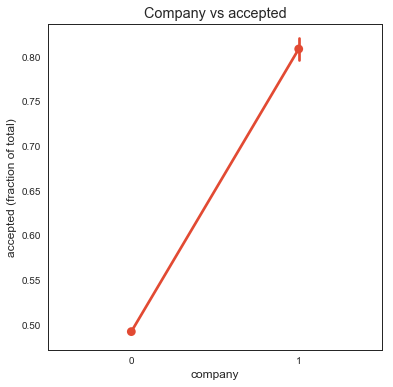

In [6]:
fig, sax=plt.subplots(1,1,figsize=(6,6))
sns.pointplot(x='company',y='label',data=data1,ax=sax)
sax.set(ylabel = 'accepted (fraction of total)')
#sax[0,0].set_ylim(0,0.85)
sax.set_title('Company vs accepted')
fig.savefig('company.png')

Text(0.5,1,'loan type state 2and4 vs accepted')

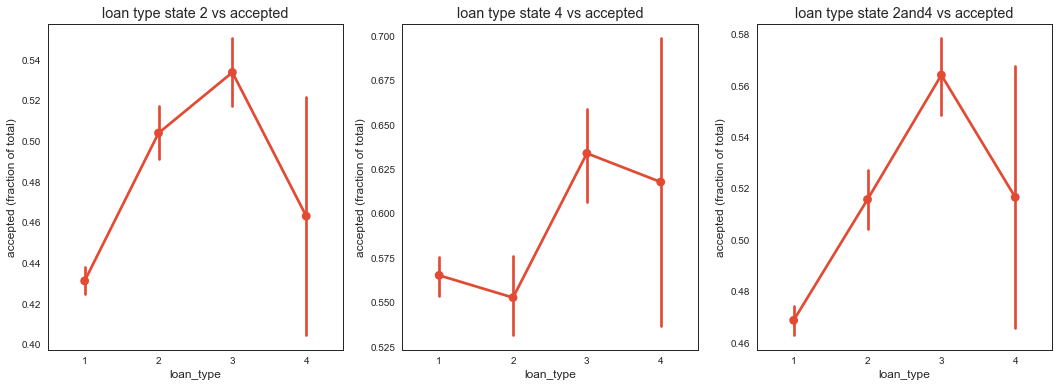

In [65]:
#pointplots
fig, (sax1,sax2,sax3)=plt.subplots(1,3,figsize=(18,6))
sns.pointplot(x='loan_type',y='label',data=data1[data1['state_code']==2],ax=sax1)
sax1.set(ylabel = 'accepted (fraction of total)')
#sax[0,0].set_ylim(0,0.85)
sax1.set_title('loan type state 2 vs accepted')

sns.pointplot(x='loan_type',y='label',data=data1[data1['state_code']==4],ax=sax2)
sax2.set(ylabel = 'accepted (fraction of total)')
#sax[0,1].set_ylim(0,0.85)
sax2.set_title('loan type state 4 vs accepted')

sns.pointplot(x='loan_type',y='label',data=data1[(data1['state_code']==2) | (data1['state_code']==4)],ax=sax3)
sax3.set(ylabel = 'accepted (fraction of total)')
#sax[1,0].set_ylim(0,0.85)
sax3.set_title('loan type state 2and4 vs accepted')

In [ ]:
#lets investigate loan amount

#pointplots
fig, sax=plt.subplots(4,2,figsize=(12,24))
sns.pointplot(x='company',y='label',data=data1,ax=sax[0,0])
sax[0,0].set(ylabel = 'accepted (fraction of total)')
sax[0,0].set_ylim(0,0.85)
sax[0,0].set_title('Company vs accepted')

sns.pointplot(x='property_type',y='label',data=data1,ax=sax[0,1])
sax[0,1].set(ylabel = 'accepted (fraction of total)')
sax[0,1].set_ylim(0,0.85)
sax[0,1].set_title('property type vs accepted')

sns.pointplot(x='preapproval',y='label',data=data1,ax=sax[1,0])
sax[1,0].set(ylabel = 'accepted (fraction of total)')
sax[1,0].set_ylim(0,0.85)
sax[1,0].set_title('preapproval vs accepted')

sns.pointplot(x='applicant_ethnicity',y='label',data=data1,ax=sax[1,1])
sax[1,1].set(ylabel = 'accepted (fraction of total)')
sax[1,1].set_ylim(0,0.85)
sax[1,1].set_title('ethnicity vs accepted')

sns.pointplot(x='applicant_race',y='label',data=data1,ax=sax[2,0])
sax[2,0].set(ylabel = 'accepted (fraction of total)')
sax[2,0].set_xticklabels(sax[2,0].get_xticklabels(), rotation=45)
sax[2,0].set_ylim(0,0.85)
sax[2,0].set_title('race vs accepted')

sns.pointplot(x='applicant_sex',y='label',data=data1,ax=sax[2,1])
sax[2,1].set(ylabel = 'accepted (fraction of total)')
sax[2,1].set_ylim(0,0.85)
sax[2,1].set_title('sex vs accepted')

sns.pointplot(x='co_applicant',y='label',data=data1,ax=sax[3,0])
sax[3,0].set(ylabel = 'accepted (fraction of total)')
sax[3,0].set_ylim(0,0.85)
sax[3,0].set_title('co applicant vs accepted')

sns.pointplot(x='skippers',y='label',data=data1,ax=sax[3,1])
sax[3,1].set(ylabel = 'accepted (fraction of total)')
sax[3,1].set_ylim(0,0.85)
sax[3,1].set_title('skippers vs accepted')
fig.savefig('snsbarplots.png')

Text(0.5,1,'applicant income vs loan amount')

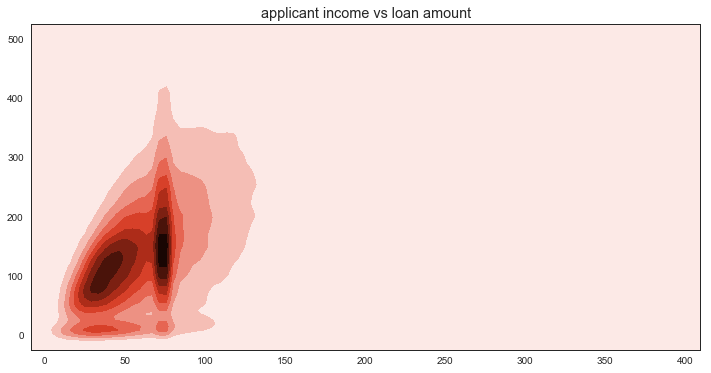

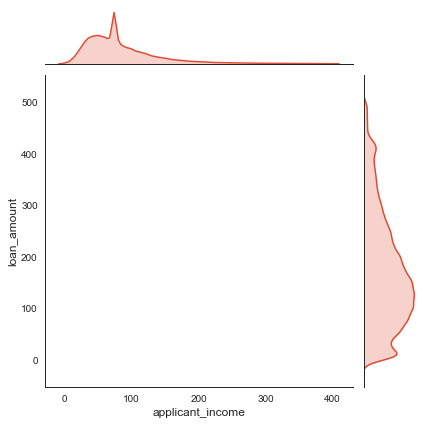

In [76]:
fig, qaxis = plt.subplots(1,1,figsize=(12,6))
sns.jointplot(x='applicant_income',y='loan_amount',data=data1,kind='kde',ax=qaxis)
qaxis.set_title('applicant income vs loan amount')

In [ ]:
fig, qaxis = plt.subplots(1,1,figsize=(6,6))
sns.violinplot(x='loan_purpose',y='loan_amount',hue = 'label', data=data1,ax=qaxis[0],showmeans=True)
qaxis[0].set_title('loan amount vs label')

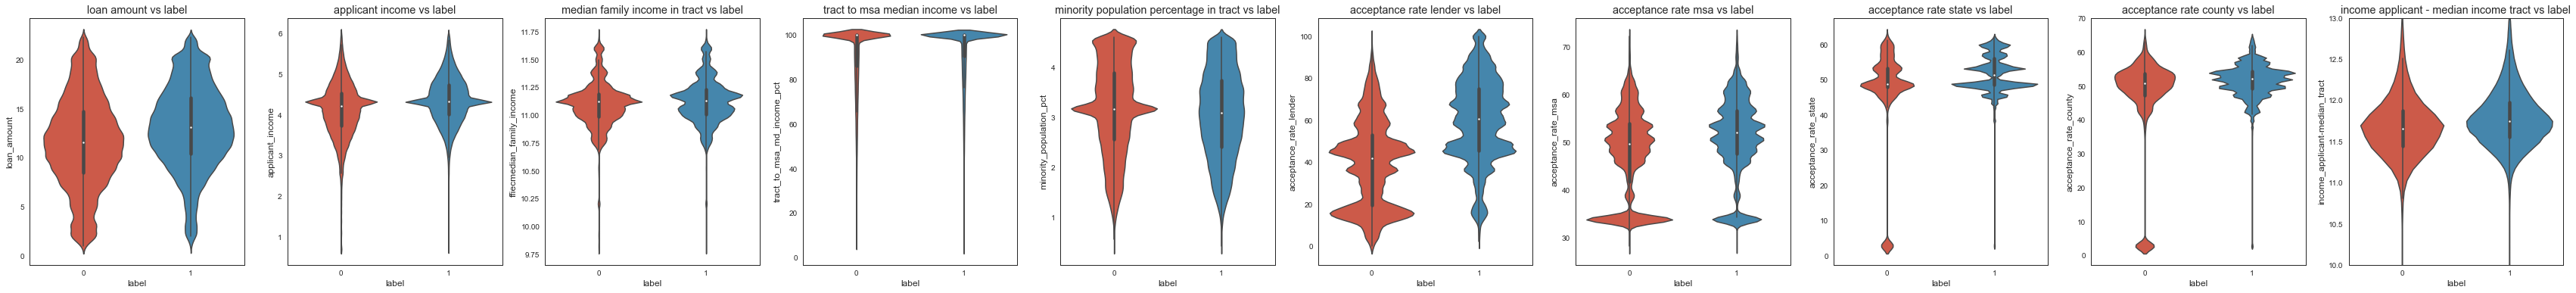

In [91]:
#numerical features - label
#num feat. vs label: num - cat
fig, qaxis = plt.subplots(1,10,figsize=(60,6))
sns.violinplot(x='label',y='loan_amount',data=data1,ax=qaxis[0],showmeans=True)
qaxis[0].set_title('loan amount vs label')

sns.violinplot(x='label',y='applicant_income',data=data1,ax=qaxis[1],showmeans=True)
qaxis[1].set_title('applicant income vs label')

# sns.boxplot(x='label',y='population',data=data1,ax=qaxis[2])
# qaxis[2].set_title('population in tract vs label')
# qaxis[2].set_ylim(7,10)

sns.violinplot(x='label',y='ffiecmedian_family_income',data=data1,ax=qaxis[2],showmeans=True)
qaxis[2].set_title('median family income in tract vs label')

sns.violinplot(x='label',y='tract_to_msa_md_income_pct',data=data1,ax=qaxis[3],showmeans=True)
qaxis[3].set_title('tract to msa median income vs label')

# sns.boxplot(x='label',y='number_of_owner-occupied_units',data=data1,ax=qaxis[5])
# qaxis[5].set_title('#occupied living units in tract vs label')

# sns.boxplot(x='label',y='number_of_1_to_4_family_units',data=data1,ax=qaxis[6])
# qaxis[6].set_title('1-4 family units in tract vs label')

sns.violinplot(x='label',y='minority_population_pct',data=data1,ax=qaxis[4],showmeans=True)
qaxis[4].set_title('minority population percentage in tract vs label')

# sns.boxplot(x='label',y='MHE',data=data1,ax=qaxis[9])
# qaxis[9].set_title('MHE vs label')
# qaxis[9].set_ylim(-500,500)

sns.violinplot(x='label',y='acceptance_rate_lender',data=data1,ax=qaxis[5],showmeans=True)
qaxis[5].set_title('acceptance rate lender vs label')

sns.violinplot(x='label',y='acceptance_rate_msa',data=data1,ax=qaxis[6],showmeans=True)
qaxis[6].set_title('acceptance rate msa vs label')

sns.violinplot(x='label',y='acceptance_rate_state',data=data1,ax=qaxis[7],showmeans=True)
qaxis[7].set_title('acceptance rate state vs label')

sns.violinplot(x='label',y='acceptance_rate_county',data=data1,ax=qaxis[8],showmeans=True)
qaxis[8].set_title('acceptance rate county vs label')

sns.violinplot(x='label',y='income_applicant-median_tract',data=data1,ax=qaxis[9],showmeans=True)
qaxis[9].set_title('income applicant - median income tract vs label')
qaxis[9].set_ylim(10,13)
fig.savefig('boxplots.png')

C:\Users\Joeri Kiekens\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


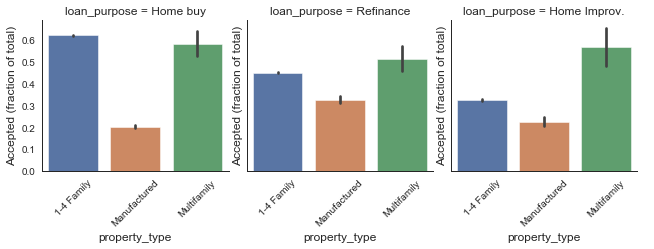

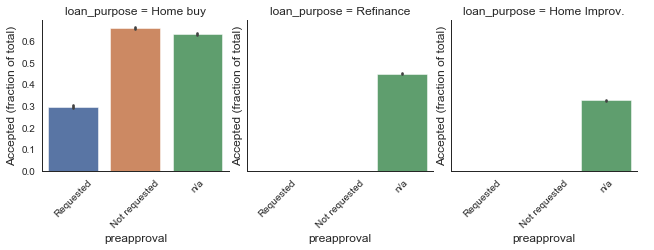

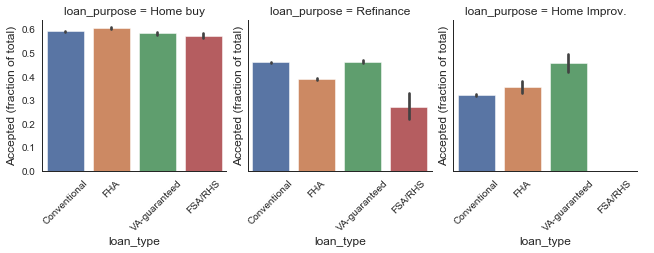

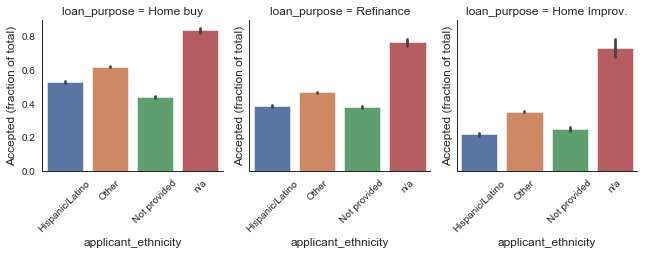

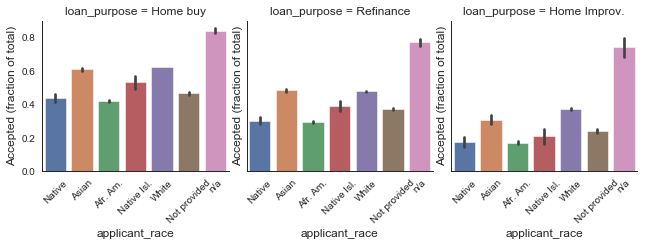

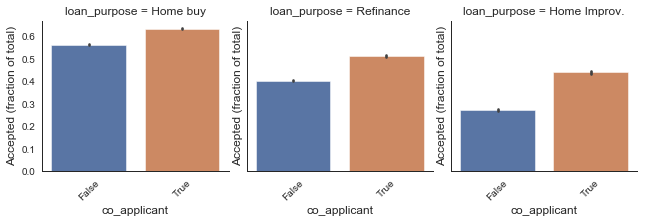

In [77]:
# map_loan_p = {'1': 'Home buy','2': 'Home Improv.','3': 'Refinance'}
# map_prop_t = {'1':'1-4 Family','2':'Manufactured','3':'Multifamily'}
# map_preap = {'1':'Requested','2':'Not requested','3':'n/a'}
# map_eth = {'1':'Hispanic/Latino', '2':'Other','3':'Not provided','4':'n/a'}
#map_loant = {'1':'Conventional','2':'FHA','3':'VA-guaranteed'}

# map_race = {'1':'Native','2':'Asian','3':'Afr. Am.','4':'Native Isl.','5':'White','6':'Not provided','7':'n/a'}
# map_sex = {'1':'Male','2':'Female','3':'Not provided','4':'n/a'}

a = sns.FacetGrid(data1,col='loan_purpose')
a=a.map(sns.barplot,'property_type','label',order = ['1-4 Family','Manufactured','Multifamily'],ci=95.0,palette='deep')
for ax in a.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_ylabel('Accepted (fraction of total)')
a.add_legend()
a.savefig('boxplotsa.png')

b = sns.FacetGrid(data1,col='loan_purpose')
b=b.map(sns.barplot,'preapproval','label',order = ['Requested','Not requested','n/a'],ci=95.0,palette='deep')
for ax in b.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_ylabel('Accepted (fraction of total)')
b.add_legend()
b.savefig('boxplotsb.png')

c = sns.FacetGrid(data1,col='loan_purpose')
c=c.map(sns.barplot,'loan_type','label',order = ['Conventional','FHA','VA-guaranteed','FSA/RHS'],ci=95.0,palette='deep')
for ax in c.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_ylabel('Accepted (fraction of total)')
c.add_legend()
c.savefig('boxplotsc.png')

d = sns.FacetGrid(data1,col='loan_purpose')
d=d.map(sns.barplot,'applicant_ethnicity','label',order = ['Hispanic/Latino', 'Other','Not provided','n/a'],ci=95.0,palette='deep')
for ax in d.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_ylabel('Accepted (fraction of total)')
d.add_legend()
d.savefig('boxplotsd.png')

e = sns.FacetGrid(data1,col='loan_purpose')
e=e.map(sns.barplot,'applicant_race','label',order = ['Native','Asian','Afr. Am.','Native Isl.','White','Not provided','n/a'],ci=95.0,palette='deep')
for ax in e.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_ylabel('Accepted (fraction of total)')
e.add_legend()
e.savefig('boxplotse.png')

f = sns.FacetGrid(data1,col='loan_purpose')
f=f.map(sns.barplot,'co_applicant','label',ci=95.0,palette='deep')
for ax in f.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_ylabel('Accepted (fraction of total)')
f.add_legend()
f.savefig('boxplotsf.png')


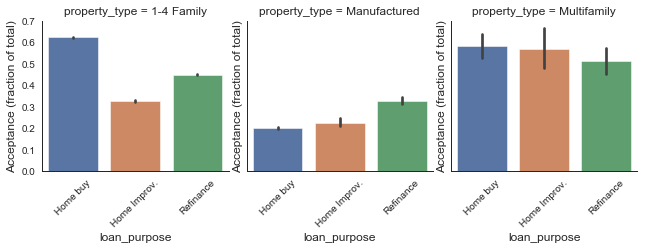

In [50]:
a = sns.FacetGrid(data1,col='property_type')
a=a.map(sns.barplot,'loan_purpose','label',order = ['Home buy','Home Improv.','Refinance'],ci=95.0,palette='deep')
for ax in a.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_ylabel('Acceptance (fraction of total)')
a.add_legend()
a.savefig('boxplotsa.png')

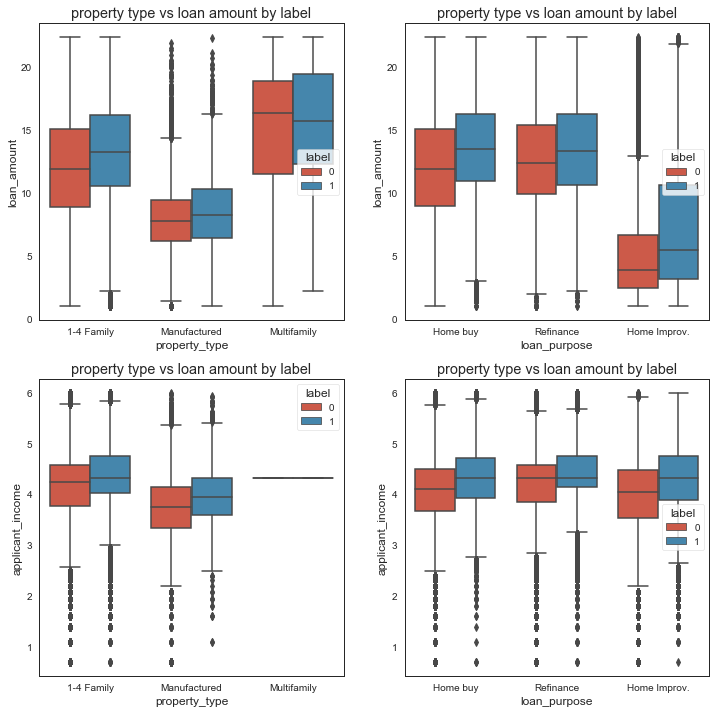

In [18]:
fig, qaxis = plt.subplots(2,2,figsize=(12,12))
sns.boxplot(x='property_type',y='loan_amount',hue='label',data=data1,ax=qaxis[0,0])
qaxis[0,0].set_title('property type vs loan amount by label')

sns.boxplot(x='loan_purpose',y='loan_amount',hue='label',data=data1,ax=qaxis[0,1])
qaxis[0,1].set_title('property type vs loan amount by label')

sns.boxplot(x='property_type',y='applicant_income',hue='label',data=data1,ax=qaxis[1,0])
qaxis[1,0].set_title('property type vs loan amount by label')

sns.boxplot(x='loan_purpose',y='applicant_income',hue='label',data=data1,ax=qaxis[1,1])
qaxis[1,1].set_title('property type vs loan amount by label')

fig.savefig('boxies.png')

Text(0.5,1,'property type vs number of fam units label')

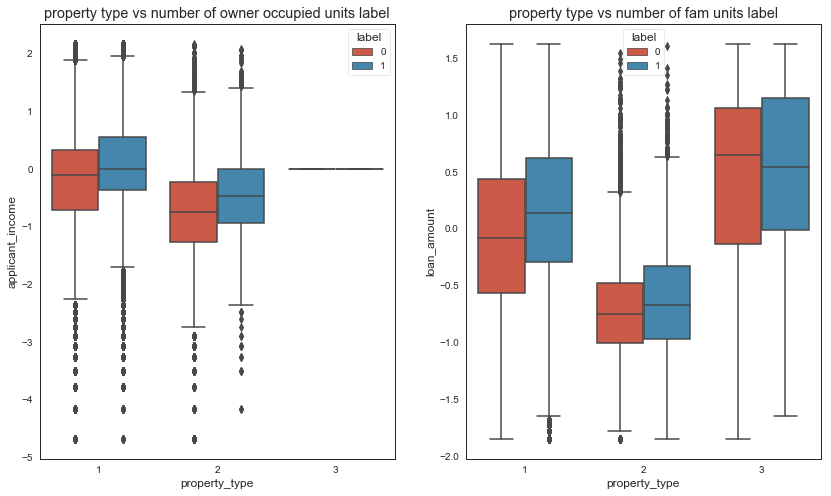

In [45]:
#cat cat cat 3D plots
fig, qaxis = plt.subplots(1,2,figsize=(14,8))
sns.boxplot(x='property_type',y='applicant_income',hue='label',data=data1,ax=qaxis[0])
qaxis[0].set_title('property type vs number of owner occupied units label')

sns.boxplot(x='property_type',y='loan_amount',hue='label',data=data1,ax=qaxis[1])
qaxis[1].set_title('property type vs number of fam units label')

# sns.boxplot(x='property_type',y='acceptance_rate_lender',hue='label',data=data1,ax=qaxis[2])
# qaxis[2].set_title('property type vs minority pop label')

Modelling

In [82]:
#train scaler on train dataset and then apply to train set and test set

#standard scaler zscore
#scaler = StandardScaler().fit(data1[['acceptance_rate_lender','acceptance_rate_location','income_applicant-median_tract','income_applicant-median_msa']])
zscore_scaler_cols = ['loan_amount','applicant_income','ffiecmedian_family_income','income_applicant-median_tract','acceptance_rate_lender','acceptance_rate_msa','acceptance_rate_state','acceptance_rate_county']
scaler = RobustScaler().fit(data1[zscore_scaler_cols])
data1[zscore_scaler_cols]=scaler.transform(data1[zscore_scaler_cols])
data_test[zscore_scaler_cols]=scaler.transform(data_test[zscore_scaler_cols])

#minmax scaler
mm_scaler_cols = ['minority_population_pct','tract_to_msa_md_income_pct']
scalermm=MinMaxScaler().fit(data1[mm_scaler_cols])
data1[mm_scaler_cols]=scalermm.transform(data1[mm_scaler_cols])
data_test[mm_scaler_cols]=scalermm.transform(data_test[mm_scaler_cols])


In [83]:
data1_x_bin = ['loan_type','property_type','loan_purpose','occupancy','preapproval','not_msa_area','applicant_ethnicity','applicant_race','company','applicant_income','minority_population_pct','ffiecmedian_family_income','tract_to_msa_md_income_pct','co_applicant','skippers','acceptance_rate_lender','acceptance_rate_msa','income_applicant-median_tract']

data1_dummy = pd.get_dummies(data1[data1_x_bin])
data_test_dummy = pd.get_dummies(data_test[data1_x_bin])

print(data1_dummy.shape)
print(data_test_dummy.shape)
print(data1_dummy.sample(10))
print(data1_dummy.dtypes)

(466668, 41)
(500000, 41)
        applicant_income  minority_population_pct  ffiecmedian_family_income  \
499321         -0.246193                 0.390727                   0.738339   
366863         -0.126722                 0.402412                   0.334052   
21022          -1.023200                 0.772264                  -0.423189   
49894          -0.473680                 0.777963                  -0.290491   
158278          0.034037                 0.600302                  -1.209984   
9328            1.153660                 0.424328                  -0.073671   
103370          0.000000                 0.900487                  -0.578261   
395626         -1.228925                 0.978237                  -0.347608   
284666         -0.354941                 0.437022                   0.265152   
407396          0.161879                 0.529029                   0.290561   

        tract_to_msa_md_income_pct  co_applicant  acceptance_rate_lender  \
499321           

In [13]:
# #output to model in Azure ML:
# data1_dummy['label']=data1['label']
# data1_dummy.to_csv('train_MLrev5.csv')
# #data1['label'].to_csv('train_ML_label.csv',header=True)
# data_test_dummy.to_csv('test_MLrev5.csv')

In [15]:
data1_dummy.head(10)

,applicant_income,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,co_applicant,acceptance_rate_lender,acceptance_rate_msa,income_applicant-median_tract,loan_type_1,loan_type_2,...,applicant_race_5,applicant_race_6,applicant_race_7,applicant_sex_1,applicant_sex_2,applicant_sex_3,applicant_sex_4,skippers_0,skippers_1,label
0,-1.420883,0.808141,-0.508672,0.488987,False,1.146956,0.009574,-0.330542,0,0,...,1,0,0,1,0,0,0,1,0,1
1,-0.332448,0.573105,-0.977968,1.000000,False,-1.030630,0.327204,-0.136997,1,0,...,1,0,0,1,0,0,0,1,0,0
2,-0.126722,0.884497,0.013391,1.000000,False,0.000000,-0.018298,-0.197327,0,1,...,1,0,0,1,0,0,0,1,0,1
3,0.447433,0.370786,0.702883,1.000000,True,0.626810,0.278021,0.317033,1,0,...,1,0,0,1,0,0,0,1,0,1
4,-0.052797,1.000000,-0.319930,0.814620,False,0.154260,0.041457,0.188151,1,0,...,0,0,0,0,1,0,0,1,0,1
5,-0.473680,0.318490,0.953627,0.964070,False,0.030173,0.606687,-0.882727,1,0,...,1,0,0,0,1,0,0,1,0,1
6,0.435174,0.688675,-0.158568,0.802831,False,0.204369,0.660405,0.699019,0,0,...,1,0,0,0,1,0,0,1,0,1
7,-0.377833,0.941790,2.218705,0.577573,True,0.792998,0.609586,-0.388053,0,1,...,1,0,0,1,0,0,0,1,0,1
8,1.531021,0.970211,-0.294781,0.612712,True,0.614641,0.041457,2.250065,1,0,...,1,0,0,1,0,0,0,1,0,1
9,0.191958,0.674930,-0.112439,1.000000,False,-1.439458,0.140314,0.204559,1,0,...,1,0,0,1,0,0,0,1,0,0


In [27]:
data1_dummy[['acceptance_rate_lender','acceptance_rate_state','acceptance_rate_msa','acceptance_rate_county','MHE']].head(10)

,acceptance_rate_lender,acceptance_rate_state,acceptance_rate_msa,acceptance_rate_county,MHE
0,1.160465,0.713491,-0.072854,-0.277648,0.300654
1,-1.069582,1.320896,0.275036,0.448120,0.359477
2,0.000000,0.000000,-0.084058,-0.011539,0.065359
3,0.665846,0.842393,0.279113,0.367993,-0.732026
4,0.216950,0.713491,0.026677,-0.255545,0.915033
5,0.033657,0.397582,0.605237,-0.415554,0.183007
6,0.238225,1.041843,0.579742,0.782960,-0.156863
7,0.790508,0.713491,0.822841,-0.337908,0.607843
8,0.656231,0.713491,0.026677,-0.255545,-3.104575
9,-1.492627,-0.322878,0.033628,-0.511747,-0.084967


In [36]:
#define model: logistic regression
logistic_mod = linear_model.LogisticRegression(C = 100)
#cv strategy
cv_split = ms.ShuffleSplit(n_splits = 5,test_size=0.3,train_size=0.65,random_state=0)
scoring = ['precision_macro', 'recall_macro', 'roc_auc','accuracy']
scores = ms.cross_validate(logistic_mod, data1_dummy, data1['label'], scoring=scoring,
                        cv=cv_split, return_train_score=False)

In [37]:
def print_format(f,x,y,z,w):
    print('Fold %2d    %4.4f        %4.4f      %4.4f      %4.4f' % (f, x, y, z,w))

def print_cv(scores):
    fold = [x + 1 for x in range(len(scores['test_precision_macro']))]
    print('         Precision     Recall       AUC        Accuracy')
    [print_format(f,x,y,z,w) for f,x,y,z,w in zip(fold, scores['test_precision_macro'], 
                                          scores['test_recall_macro'],
                                          scores['test_roc_auc'],
                                                 scores['test_accuracy'])]
    print('-' * 40)
    print('Mean       %4.3f        %4.3f      %4.3f       %4.4f ' % 
          (np.mean(scores['test_precision_macro']), np.mean(scores['test_recall_macro']), np.mean(scores['test_roc_auc']), np.mean(scores['test_accuracy'])))  
    print('Std        %4.3f        %4.3f      %4.3f       %4.4f ' % 
          (np.std(scores['test_precision_macro']), np.std(scores['test_recall_macro']), np.std(scores['test_roc_auc']), np.std(scores['test_accuracy'])))

print_cv(scores)   

         Precision     Recall       AUC        Accuracy
Fold  1    0.7204        0.7202      0.7979      0.7200
Fold  2    0.7202        0.7201      0.7979      0.7199
Fold  3    0.7194        0.7192      0.7976      0.7191
Fold  4    0.7187        0.7186      0.7958      0.7183
Fold  5    0.7206        0.7204      0.7998      0.7202
----------------------------------------
Mean       0.720        0.720      0.798       0.7195 
Std        0.001        0.001      0.001       0.0007 


In [141]:
         Precision     Recall       AUC        Accuracy
Fold  1    0.7205        0.7203      0.7979      0.7201
Fold  2    0.7203        0.7202      0.7979      0.7200
Fold  3    0.7195        0.7193      0.7978      0.7191
Fold  4    0.7188        0.7186      0.7958      0.7184
Fold  5    0.7208        0.7206      0.7998      0.7204
----------------------------------------
Mean       0.720        0.720      0.798       0.7196 
Std        0.001        0.001      0.001       0.0007 
#strict outlier rules 500 - 400 and no dropping of other features

In [ ]:
gradboost_mod = GradientBoostingClassifier(learning_rate = 0.025, n_estimators=1399, max_leaf_nodes = 70)
cv_split = ms.ShuffleSplit(n_splits = 5,test_size=0.3,train_size=0.65,random_state=0)
scoring = ['precision_macro', 'recall_macro', 'roc_auc','accuracy']
scores = ms.cross_validate(gradboost_mod, data1_dummy, data1['label'], scoring=scoring,
                        cv=cv_split, return_train_score=False)
print_cv(scores) 

In [33]:
         Precision     Recall       AUC        Accuracy
Fold  1    0.7317        0.7304      0.8115      0.7300
Fold  2    0.7322        0.7309      0.8114      0.7305
Fold  3    0.7320        0.7307      0.8116      0.7304
Fold  4    0.7304        0.7294      0.8097      0.7289
Fold  5    0.7333        0.7320      0.8135      0.7315
----------------------------------------
Mean       0.732        0.731      0.812       0.7303 
Std        0.001        0.001      0.001       0.0009 

In [34]:
# #tune hyperparameters
# param_grid = {'C':[0.1, 1, 10, 100, 1000]}

# tune_model = ms.GridSearchCV(linear_model.LogisticRegression(),param_grid=param_grid,scoring = 'roc_auc', cv=cv_split)
# tune_model.fit(data1_dummy,data1['label'])
# print(tune_model.best_params_)

In [35]:
# #tuning with feature selection
# print('Before LR RFE training shape old: ',data1_dummy.shape)
# print('Before LR training score: {:.2f}'.format(scores['test_roc_auc'].mean()*100))
# print('Before LR test score: {:.2f}'.format(scores['test_roc_auc'].mean()*100))
# print('Before LR test score 3*std: {:.2f}'.format(scores['test_roc_auc'].std()*100*3))

# logistic_mod_rfe= feature_selection.RFECV(linear_model.LogisticRegression(),step=1,scoring = 'roc_auc',cv=cv_split)
# logistic_mod_rfe.fit(data1_dummy,data1['label'])

# X_rfe = data1_dummy.columns.values[logistic_mod_rfe.get_support()]
# rfe_results=ms.cross_validate(linear_model.LogisticRegression(),data1_dummy[X_rfe],data1['label'],cv=cv_split)

# print('After LR RFE training shape new: ',data1_dummy[X_rfe].shape)


In [36]:
# print(X_rfe)
# print(rfe_results)

In [37]:
# #define model decision tree
# bagclass = BaggingClassifier(random_state=0)
# cv_split = ms.ShuffleSplit(n_splits = 5,test_size=0.3,train_size=0.6,random_state=0)
# scoring = ['precision_macro', 'recall_macro', 'roc_auc','accuracy']
# scores = ms.cross_validate(bagclass, data1_dummy, data1['label'], scoring=scoring,
#                         cv=cv_split, return_train_score=False)
# print_cv(scores)  

In [38]:
# #define random forest
# forest_mod = RandomForestClassifier(random_state=0)
# cv_split = ms.ShuffleSplit(n_splits = 5,test_size=0.3,train_size=0.6,random_state=0)
# scoring = ['precision_macro', 'recall_macro', 'roc_auc','accuracy']
# scores = ms.cross_validate(forest_mod, data1_dummy, data1['label'], scoring=scoring,
#                         cv=cv_split, return_train_score=False)
# print_cv(scores) 

In [39]:
# #xgboost model
# xgboost_mod = XGBClassifier()
# # cv_split = ms.ShuffleSplit(n_splits = 5,test_size=0.3,train_size=0.6,random_state=0)
# # scoring = ['precision_macro', 'recall_macro', 'roc_auc','accuracy']
# # scores = ms.cross_validate(xgboost_mod, data1_dummy, data1['label'], scoring=scoring,
# #                         cv=cv_split, return_train_score=False)

# print_cv(scores)  

In [40]:
# #tune hyperparameters
# #Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# grid_n_estimator = [10, 50, 100, 300]
# grid_ratio = [.1, .25, .5, .75, 1.0]
# grid_learn = [.01, .03, .05, .1, .25]
# grid_max_depth = [2, 4, 6, 8, 10, None]
# grid_min_samples = [5, 10, .03, .05, .10]
# grid_criterion = ['gini', 'entropy']
# grid_bool = [True, False]
# grid_seed = [0]


# param_grid = {
#             #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
#             'n_estimators': grid_n_estimator, #default=50
#             'learning_rate': grid_learn, #default=1
#             #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
#             'random_state': grid_seed
#             }
# tune_model = ms.GridSearchCV(GradientBoostingClassifier(),param_grid=param_grid,scoring = 'roc_auc', cv=cv_split)
# tune_model.fit(data1_dummy,data1['label'])
# print(tune_model.best_params_)

In [41]:
# # #define model: adaboost
# adab_mod = ensemble.AdaBoostClassifier(random_state=0)
# #cv strategy
# cv_split = ms.ShuffleSplit(n_splits = 10,test_size=0.3,train_size=0.6,random_state=0)
# scoring = ['precision_macro', 'recall_macro', 'roc_auc']
# scores = ms.cross_validate(adab_mod, data1_dummy, data1['label'], scoring=scoring,
#                         cv=cv_split, return_train_score=False)

# print_cv(scores)

In [42]:
# #why choose one model, when you can pick them all with voting classifier
# #http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
# #removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
# cv_split = ms.ShuffleSplit(n_splits = 1,test_size=0.3,train_size=0.6,random_state=0)
# vote_est = [
#     #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    
#     ('bc', ensemble.BaggingClassifier()),
#     ('etc',ensemble.ExtraTreesClassifier()),
#     ('gbc', ensemble.GradientBoostingClassifier()),
#     ('rfc', ensemble.RandomForestClassifier()),

#     #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
#     ('gpc', gaussian_process.GaussianProcessClassifier()),
    
#     #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
#     ('lr', linear_model.LogisticRegressionCV()),
    
#     #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
#     ('bnb', naive_bayes.BernoulliNB()),
#     ('gnb', naive_bayes.GaussianNB()),
    
#     #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
#     ('knn', neighbors.KNeighborsClassifier()),
    
#     #SVM: http://scikit-learn.org/stable/modules/svm.html
#     ('svc', svm.SVC(probability=True)),
    
#     #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
#    ('xgb', XGBClassifier())

# ]


# #Hard Vote or majority rules
# vote_hard = VotingClassifier(estimators = vote_est , voting = 'hard')
# vote_hard_cv = ms.cross_validate(vote_hard, data1_dummy, data1['label'], cv  = cv_split)

In [44]:
# #predict
# gradboost_mod.fit(data1_dummy,data1['label'])
# preds = gradboost_mod.predict(data_test_dummy)

In [45]:
# #submission
# submission = pd.DataFrame({'row_id':data_raw['row_id'], 'accepted':preds})
# submission.to_csv('submission.csv',index=False)

In [46]:
# spark cluster
# username: joerikiekens
#     pw: Nee7pie3!!
#         sshuser